Unsupervised Capstone Project Presentation: Grouping Factors In Health Insurance Premium Pricing

In [1]:
!jupyter-nbconvert --to slides insurance-premiums.ipynb --post serve

[NbConvertApp] Converting notebook insurance-premiums.ipynb to slides
[NbConvertApp] Writing 4942989 bytes to insurance-premiums.slides.html
[NbConvertApp] Redirecting reveal.js requests to https://cdnjs.cloudflare.com/ajax/libs/reveal.js/3.5.0
Serving your slides at http://127.0.0.1:8000/insurance-premiums.slides.html
Use Control-C to stop this server
^C

Interrupted


Purpose:

Use clustering techniques to determine grouping patterns of policy holders, differentiating between groups which include more smokers versus those that include few smokers, with younger policy holders for example, this will help in the process of determining medical premium pricing. 

Introduction:

We will be applying multiple types of unsupervised learning algorithms to this medical insurance premium dataset. We will be looking at common clustering models as well as common dimensionality reduction techniques as well. I will then determine which performs best in terms of finding similarities between variables and retaining a high level of density. 

Data:

The Insurance Prediction Premium dataset was pulled from Kaggle, and it contains 4 numerical features (age, bmi, children and expenses) as well as 3 nominal features (sex, smoker and region). This dataset allows us to draw conclusions around medical premium pricing based on the individual's personal life factors and medical expenses.

The data was obtained from the Machine Learning course website (Spring 2017) from Professor Eric Suess. 

The average age, number of children, bmi, and medical expenses, is 39 years old, 30 bmi, 1 child, and 13,270. 

In [ ]:
import numpy as np 
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans #k-means model
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
import math


from sklearn.model_selection import train_test_split
from sklearn import metrics #evaluating clusters

from scipy.cluster.hierarchy import dendrogram, linkage #hierarchical clustering model
from sklearn.cluster import AgglomerativeClustering

from sklearn.cluster import DBSCAN #DBSCAN clustering model

from matplotlib.patches import Ellipse #clustering with GMM model (gaussan mixture model)
from sklearn.mixture import GaussianMixture

from sklearn.decomposition import PCA #dimensionality reduction with PCA

from sklearn.manifold import TSNE #dimensionality reduction with t-SNE
import time

#dimensionality reduction with UMAP
import umap

Upload Our Data

In [ ]:
insurance_df = pd.read_csv('insurance.csv')

Exploration Phase

In [4]:
insurance_df

age     sex   bmi  children smoker     region  expenses
0      19  female  27.9         0    yes  southwest  16884.92
1      18    male  33.8         1     no  southeast   1725.55
2      28    male  33.0         3     no  southeast   4449.46
3      33    male  22.7         0     no  northwest  21984.47
4      32    male  28.9         0     no  northwest   3866.86
...   ...     ...   ...       ...    ...        ...       ...
1333   50    male  31.0         3     no  northwest  10600.55
1334   18  female  31.9         0     no  northeast   2205.98
1335   18  female  36.9         0     no  southeast   1629.83
1336   21  female  25.8         0     no  southwest   2007.95
1337   61  female  29.1         0    yes  northwest  29141.36

[1338 rows x 7 columns]

In [5]:
insurance_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   expenses  1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [6]:
insurance_df.describe()

age          bmi     children      expenses
count  1338.000000  1338.000000  1338.000000   1338.000000
mean     39.207025    30.665471     1.094918  13270.422414
std      14.049960     6.098382     1.205493  12110.011240
min      18.000000    16.000000     0.000000   1121.870000
25%      27.000000    26.300000     0.000000   4740.287500
50%      39.000000    30.400000     1.000000   9382.030000
75%      51.000000    34.700000     2.000000  16639.915000
max      64.000000    53.100000     5.000000  63770.430000

Cleaning Phase


Checking for null values

In [7]:
total_missing = insurance_df.isnull().sum().sort_values(ascending=False)
percent_missing = (insurance_df.isnull().sum()/insurance_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total_missing, percent_missing], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

Total  Percent
expenses      0      0.0
region        0      0.0
smoker        0      0.0
children      0      0.0
bmi           0      0.0
sex           0      0.0
age           0      0.0

There are no missing values


First we'll encode the nominal variables using one-hot encoding, then we'll check for outliers

In [8]:
insurance_df = pd.concat([insurance_df, pd.get_dummies(insurance_df["sex"], drop_first = True)], axis =1)

In [9]:
insurance_df = pd.concat([insurance_df, pd.get_dummies(insurance_df["smoker"], drop_first = True)], axis =1)

In [10]:
insurance_df = pd.concat([insurance_df, pd.get_dummies(insurance_df["region"], drop_first = True)], axis =1) 

We drop the original variables because we do not want duplicates effecting our explanatory power

In [11]:
insurance_df = insurance_df.drop(['sex', 'smoker', 'region'], axis = 1)

In [12]:
insurance_df.head()

age   bmi  children  expenses  male  yes  northwest  southeast  southwest
0   19  27.9         0  16884.92     0    1          0          0          1
1   18  33.8         1   1725.55     1    0          0          1          0
2   28  33.0         3   4449.46     1    0          0          1          0
3   33  22.7         0  21984.47     1    0          1          0          0
4   32  28.9         0   3866.86     1    0          1          0          0

In [13]:
#check for outliers

cl = insurance_df.columns
cl= cl[0:6]

plt.figure(figsize = (10,50)) 
print(cl)
for i, column in enumerate(insurance_df[cl]): 
  plt.subplot(12, 2, i + 1) 
  sns.boxplot(x=column, data=insurance_df[cl], orient = 'v')

plt.tight_layout() 

Index(['age', 'bmi', 'children', 'expenses', 'male', 'yes'], dtype='object')


We can see there are a few variables with outliers, we'll handle them either with winsorization. 

In [14]:
from scipy.stats.mstats import winsorize

insurance_df['winsorized_expenses'] = winsorize(insurance_df["expenses"], (0.20, 0))
insurance_df['winsorized_bmi'] = winsorize(insurance_df["bmi"], (0.10, 0))

In [15]:
insurance_df = insurance_df.drop(['expenses', 'bmi'], axis = 1)

In [16]:
insurance_df.head()

age  children  male  yes  northwest  southeast  southwest  \
0   19         0     0    1          0          0          1   
1   18         1     1    0          0          1          0   
2   28         3     1    0          0          1          0   
3   33         0     1    0          1          0          0   
4   32         0     1    0          1          0          0   

   winsorized_expenses  winsorized_bmi  
0             16884.92            27.9  
1              3989.84            33.8  
2              4449.46            33.0  
3             21984.47            23.0  
4              3989.84            28.9

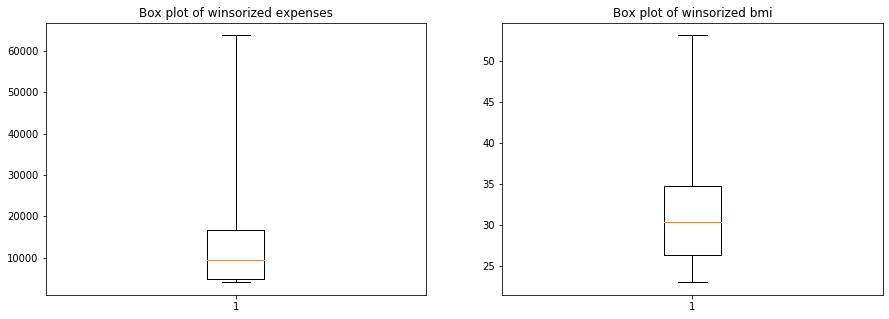

In [17]:
plt.figure(figsize = (15,5))

plt.subplot(1,2,1)
plt.boxplot(insurance_df["winsorized_expenses"], whis = 5)
plt.title("Box plot of winsorized expenses")

plt.subplot(1,2,2)
plt.boxplot(insurance_df["winsorized_bmi"], whis = 5)
plt.title("Box plot of winsorized bmi")
plt.show()

We can see that the outliers have been dealt with now we can move forward with the modeling phase

Modeling Phase:

Let's begin with a few clustering algorithms, starting with K-Means

First we standardize the data and fit the model

In [18]:
# Standarizing the features
scaler = StandardScaler()
X_std = scaler.fit_transform(insurance_df)

In [19]:

kmeans_cluster = KMeans(n_clusters=3, random_state=123)

# Fit model
k_means = KMeans(n_clusters=2, random_state=123)
%timeit k_means.fit(X_std)
pred = k_means.predict(X_std)


51.5 ms ± 4.55 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


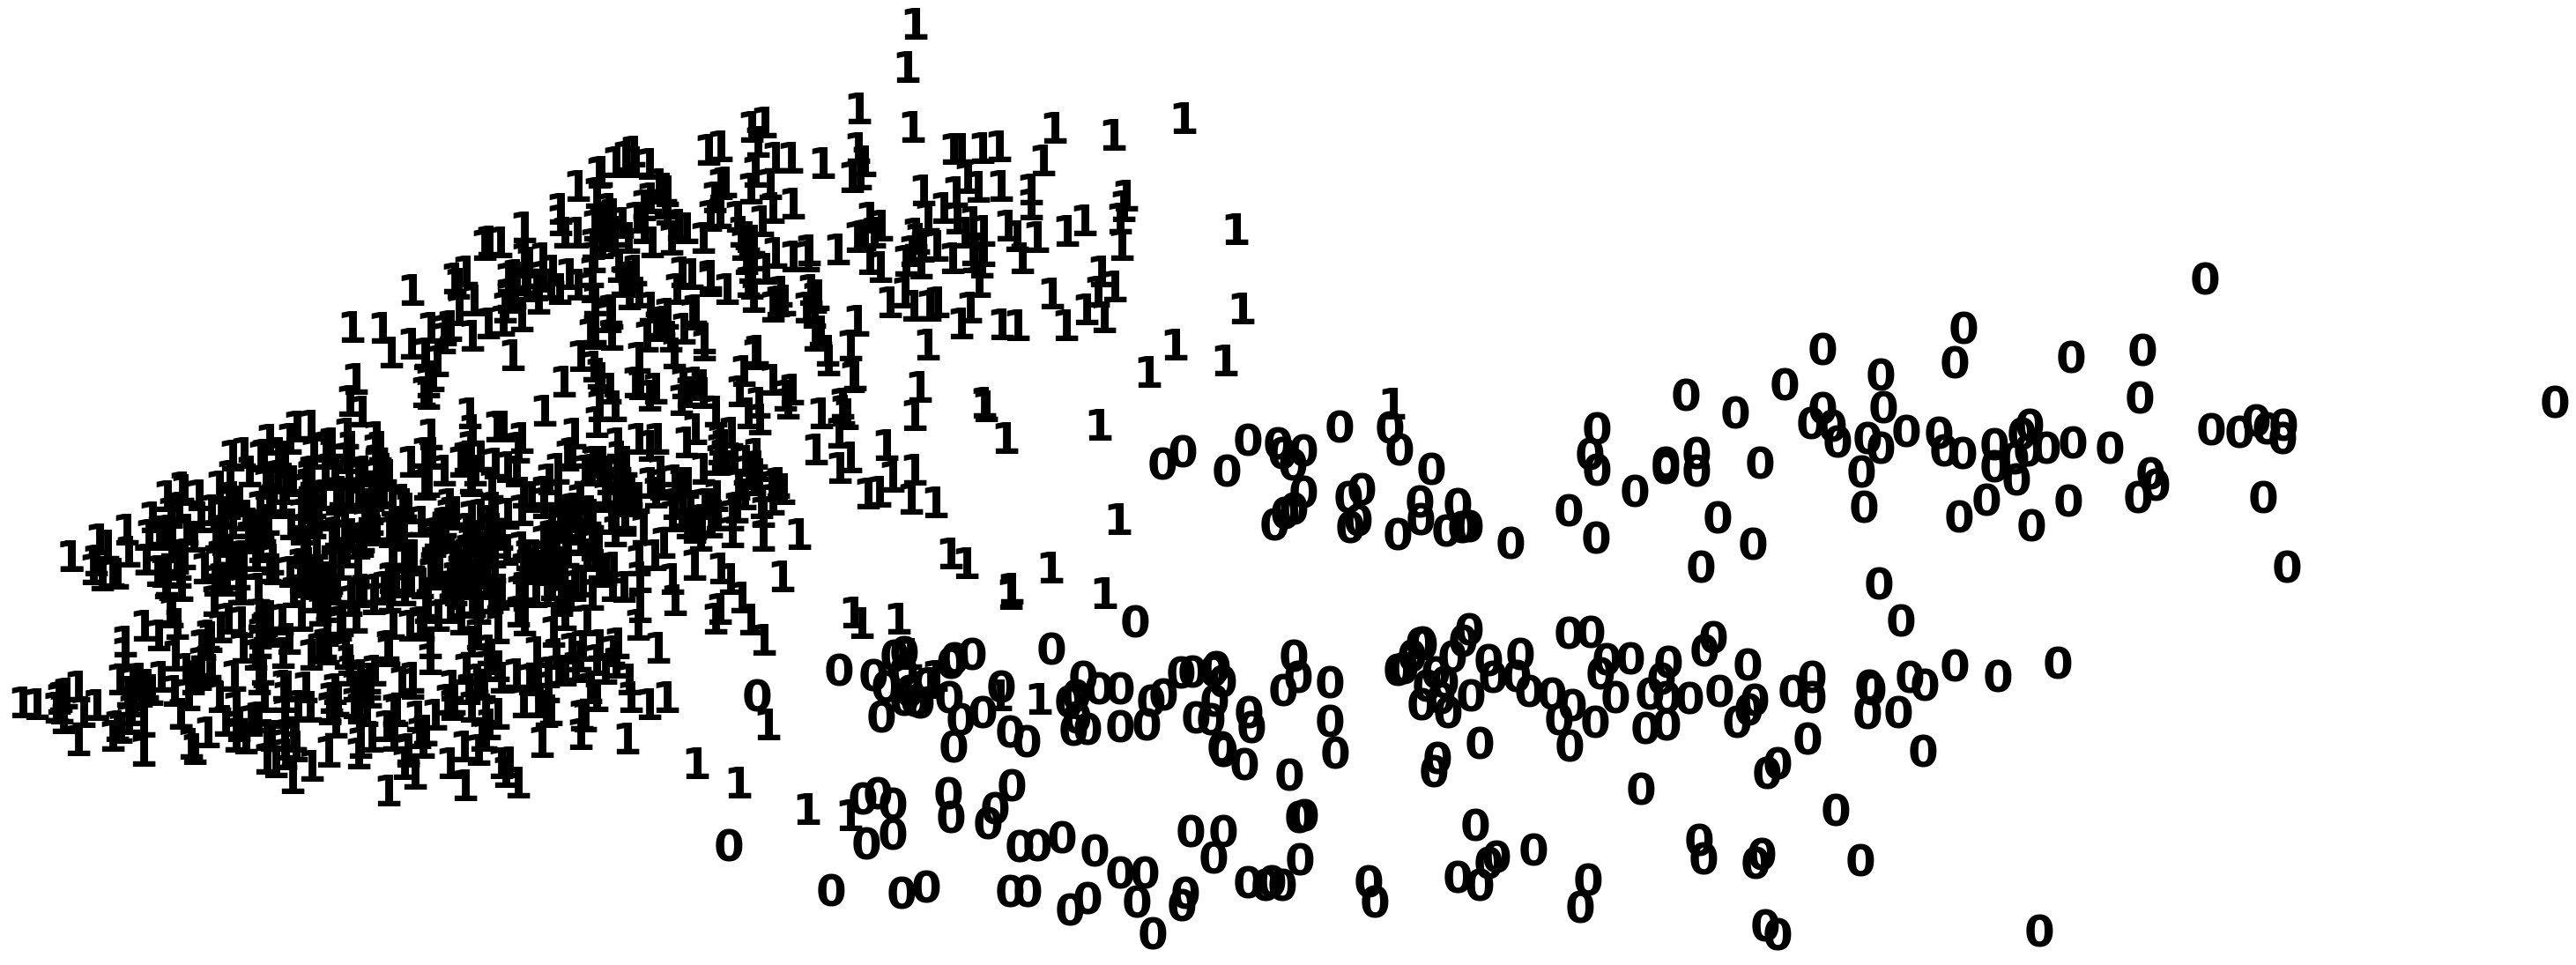

In [20]:
pca = PCA(n_components=2).fit_transform(X_std) #minimize variance with PCA

plt.figure(figsize=(7,3))
colours = 'rbg'
for i in range(pca.shape[0]):
    plt.text(pca[i, 0], pca[i, 1], str(pred[i]), 
             fontdict={'weight': 'bold', 'size': 50} 
        )

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()


We see it took 45 miliseconds to run, now let's plot our data

Evaluation: 

Excellent clustering definition between our classes, let's try k-means mini batch which is more efficient in run time

In [21]:
mini_batch_k_means = MiniBatchKMeans(n_clusters=2, random_state=123)
%timeit mini_batch_k_means.fit(X_std)
pred_mini = mini_batch_k_means.predict(X_std)


36.8 ms ± 2.7 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


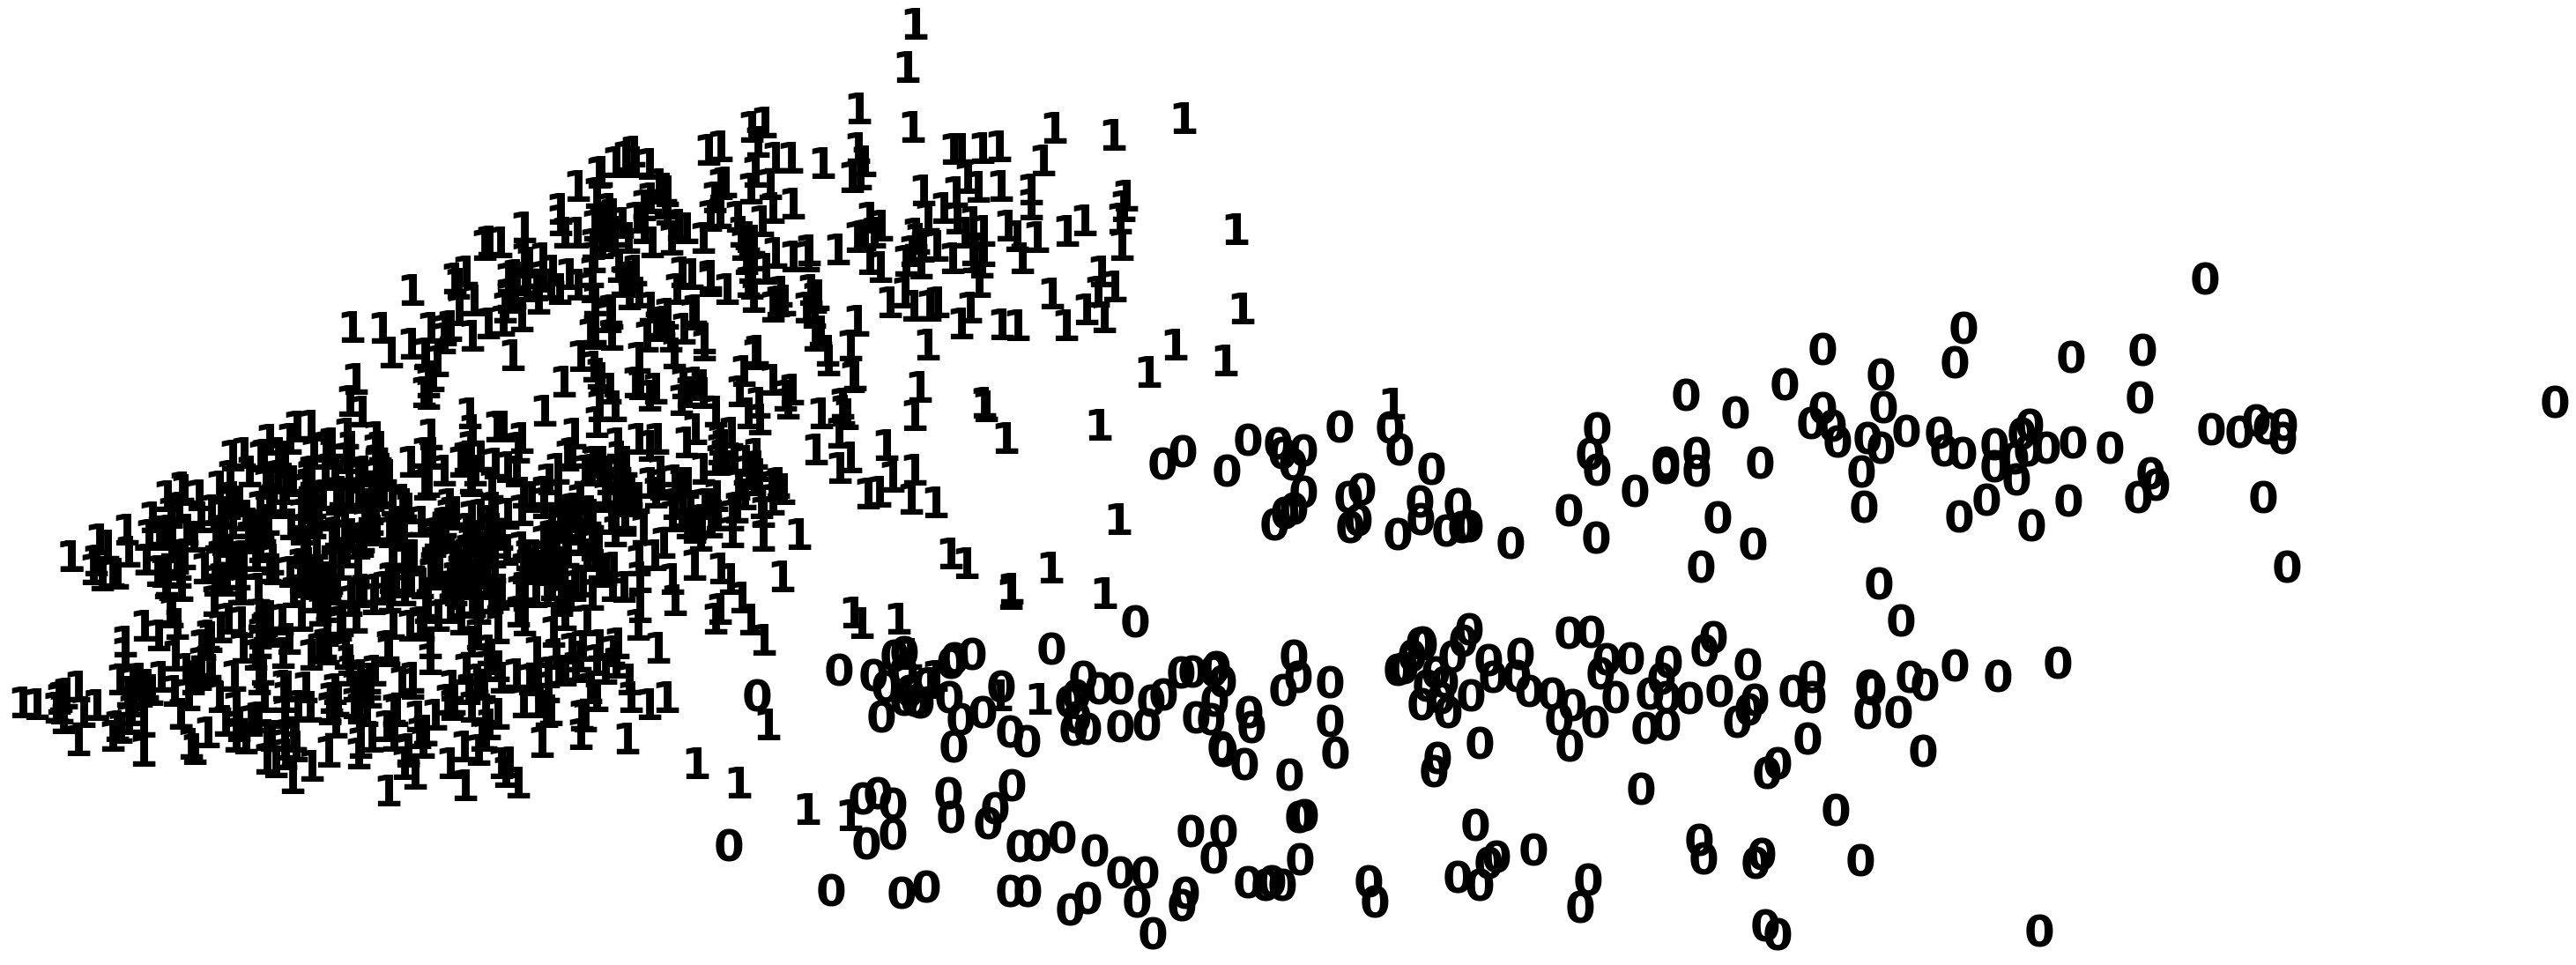

In [22]:
pca = PCA(n_components=2).fit_transform(X_std) #minimize variance with PCA

plt.figure(figsize=(7,3))
colours = 'rbg'
for i in range(pca.shape[0]):
    plt.text(pca[i, 0], pca[i, 1], str(pred_mini[i]), 
             fontdict={'weight': 'bold', 'size': 50} 
        )

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

Evaluation:

We see similar definition between classes in our clustering visualization, but this model ran roughly 31 miliseconds faster than our standard k-means model. Let's now evaluate the efficacy of our model by looking at the Silhouette score as we have no Y variable, or ground truth, in our dataset.

In [23]:
#creating silhouette score

pred_2 = KMeans(n_clusters=2, random_state=123).fit_predict(X_std)
pred_3 = KMeans(n_clusters=3, random_state=123).fit_predict(X_std)
pred_4 = KMeans(n_clusters=4, random_state=123).fit_predict(X_std)

print("Silhouette score for two cluster k-means: {}".format(
    metrics.silhouette_score(X_std, pred_2, metric='euclidean')))
print("Silhouette score for three cluster k-means: {}".format(
    metrics.silhouette_score(X_std, pred_3, metric='euclidean')))
print("Silhouette score for four cluster k-means: {}".format(
    metrics.silhouette_score(X_std, pred_4, metric='euclidean')))

Silhouette score for two cluster k-means: 0.24811656868457374
Silhouette score for three cluster k-means: 0.19176984338597966
Silhouette score for four cluster k-means: 0.22934958480328285


Evaluation:  We can see the clustering results are fairly good. Additionally, the silhouette score for our two cluster sample performs the best. The model also shows adequate density in datapoints. Let's explore two more clustering models just to compare to k-means. 

Hierarchical Clustering


In [24]:
# Defining the agglomerative clustering
agg_cluster = AgglomerativeClustering(linkage='complete', 
                                      affinity='cosine',
                                      n_clusters=3)

# Fit model
clusters = agg_cluster.fit_predict(X_std)

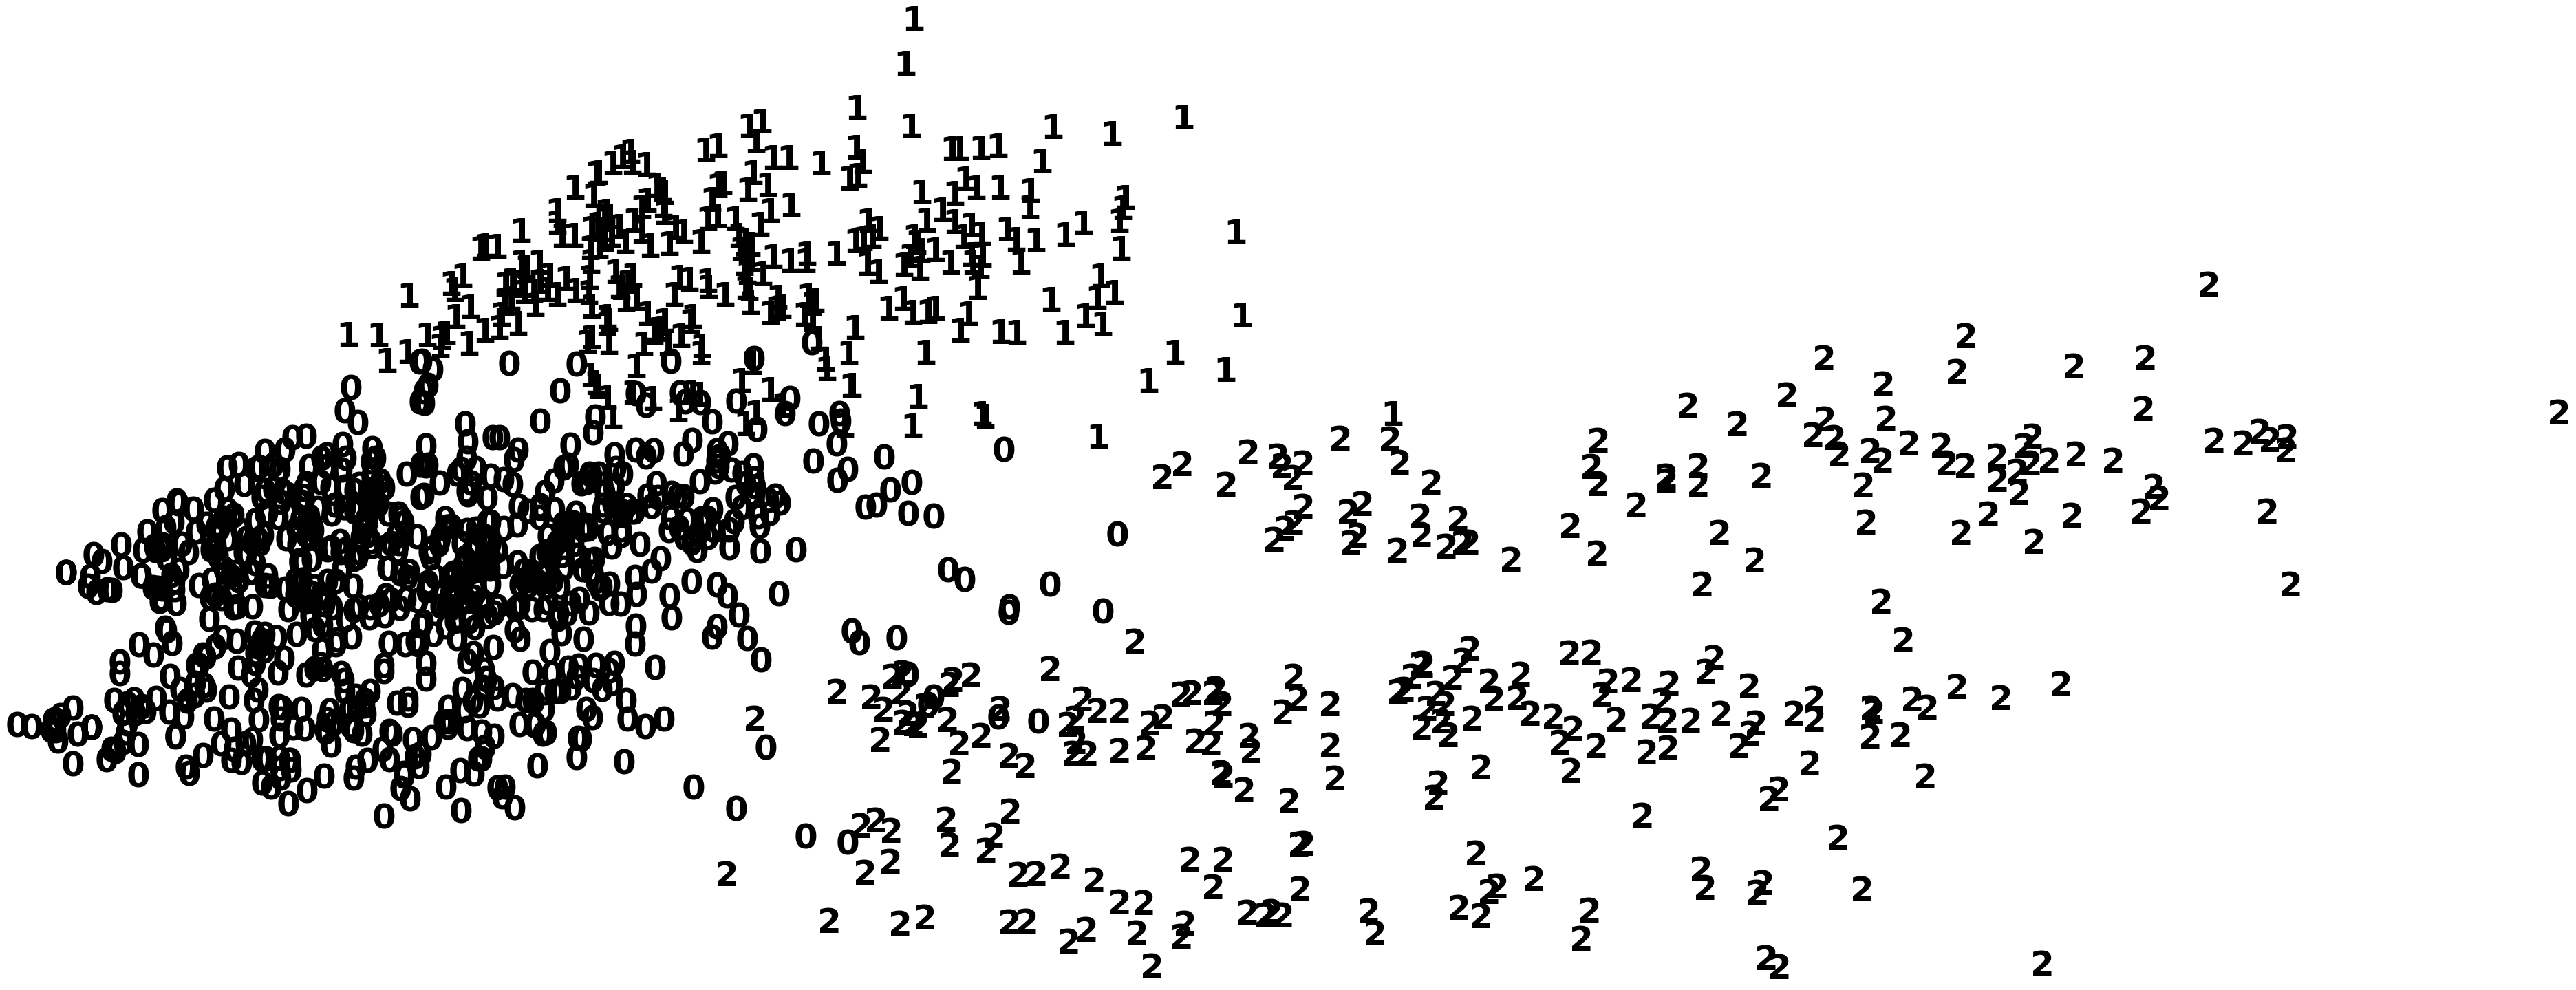

In [25]:
pca = PCA(n_components=2).fit_transform(X_std) #minimize variance with PCA

plt.figure(figsize=(9,4))
colours = 'rbg'
for i in range(pca.shape[0]):
    plt.text(pca[i, 0], pca[i, 1], str(clusters[i]), 
             fontdict={'weight': 'bold', 'size': 50} 
        )

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

let's experiment with a few different types of dengrograms, see which one is best and then run a silhouette score

In [ ]:
plt.figure(figsize=(20,10))
dendrogram(linkage(X_std, method='complete')) #complete method
plt.show()

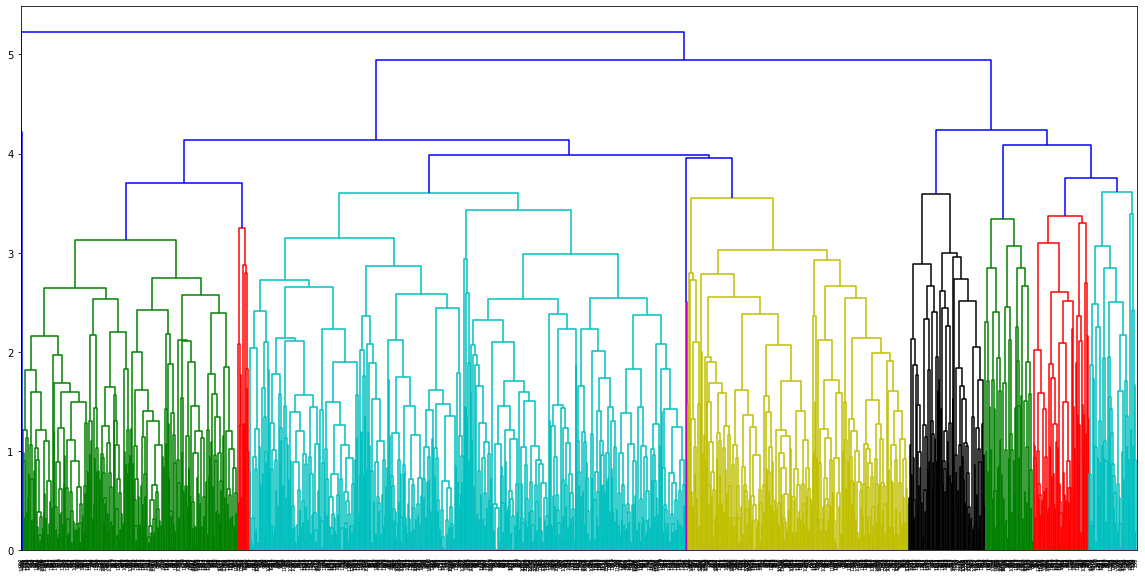

In [27]:
plt.figure(figsize=(20,10))
dendrogram(linkage(X_std, method='average')) #average method
plt.show()

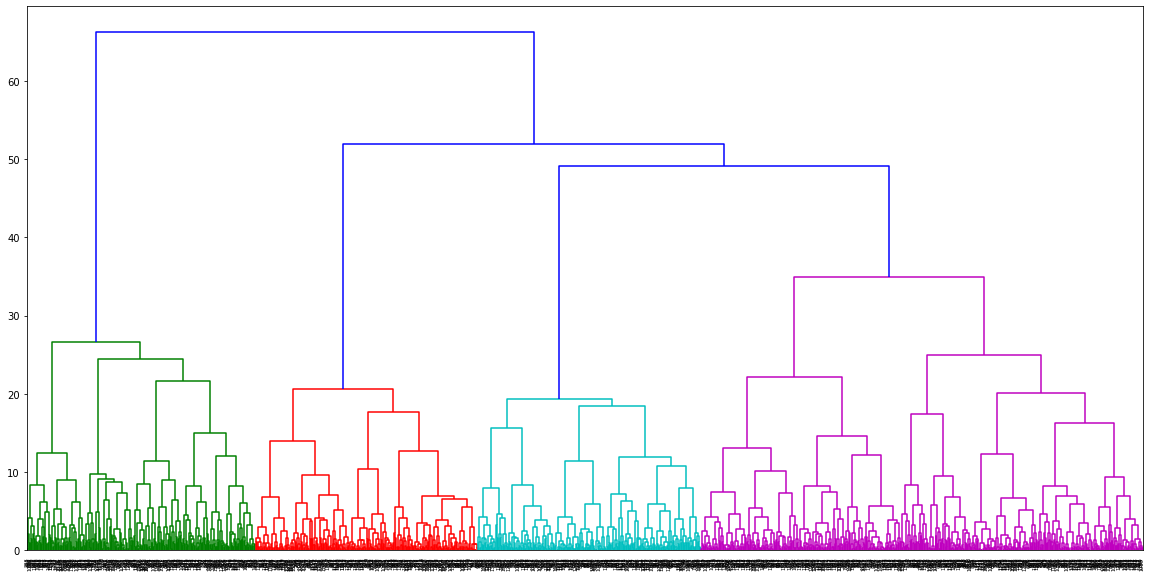

In [28]:
plt.figure(figsize=(20,10))
dendrogram(linkage(X_std, method='ward')) #ward method
plt.show()

In this selection process I would say the ward linkage method is best as it is easiest to read. Let's get our Silhouette scores.

In [29]:
linkage_methods = ["ward", "average", "complete"]

# Defining the agglomerative clustering
agg_cluster = AgglomerativeClustering(linkage="average", 
                                      affinity='cosine',
                                      n_clusters=2)

# Fit model
clusters = agg_cluster.fit_predict(insurance_df)

print("Silhouette score of linkage method average: {}".format(
    metrics.silhouette_score(X_std, clusters, metric='euclidean')))
print("------------------------------------------------")

# Defining the agglomerative clustering
agg_cluster = AgglomerativeClustering(linkage="complete", 
                                      affinity='cosine',
                                      n_clusters=2)

# Fit model
clusters = agg_cluster.fit_predict(insurance_df)

print("Silhouette score of linkage method complete: {}".format(
    metrics.silhouette_score(X_std, clusters, metric='euclidean')))
print("------------------------------------------------")

# Defining the agglomerative clustering
agg_cluster = AgglomerativeClustering(linkage="ward", 
                                      affinity='euclidean',
                                      n_clusters=2)

# Fit model
clusters = agg_cluster.fit_predict(insurance_df)

print("Silhouette score of linkage method ward: {}".format(
    metrics.silhouette_score(X_std, clusters, metric='euclidean')))

Silhouette score of linkage method average: 0.1646800686775431
------------------------------------------------
Silhouette score of linkage method complete: 0.034889587098868455
------------------------------------------------
Silhouette score of linkage method ward: 0.1968472780378789


In [30]:
#Silhouette score of linkage method average: 0.2442947544711379

#Silhouette score of linkage method complete: 0.08112708516135786

#Silhouette score of linkage method ward: 0.19684727803791843

Evaluation: We see similar a silhouette score for our average linkage method as we see in k-means two cluster sample. 

DBSCAN Clustering Model

In [31]:
# Defining the agglomerative clustering (DBSCAN)
dbscan_cluster = DBSCAN(eps=1, min_samples=1)

# Fit model
clusters = dbscan_cluster.fit_predict(X_std)

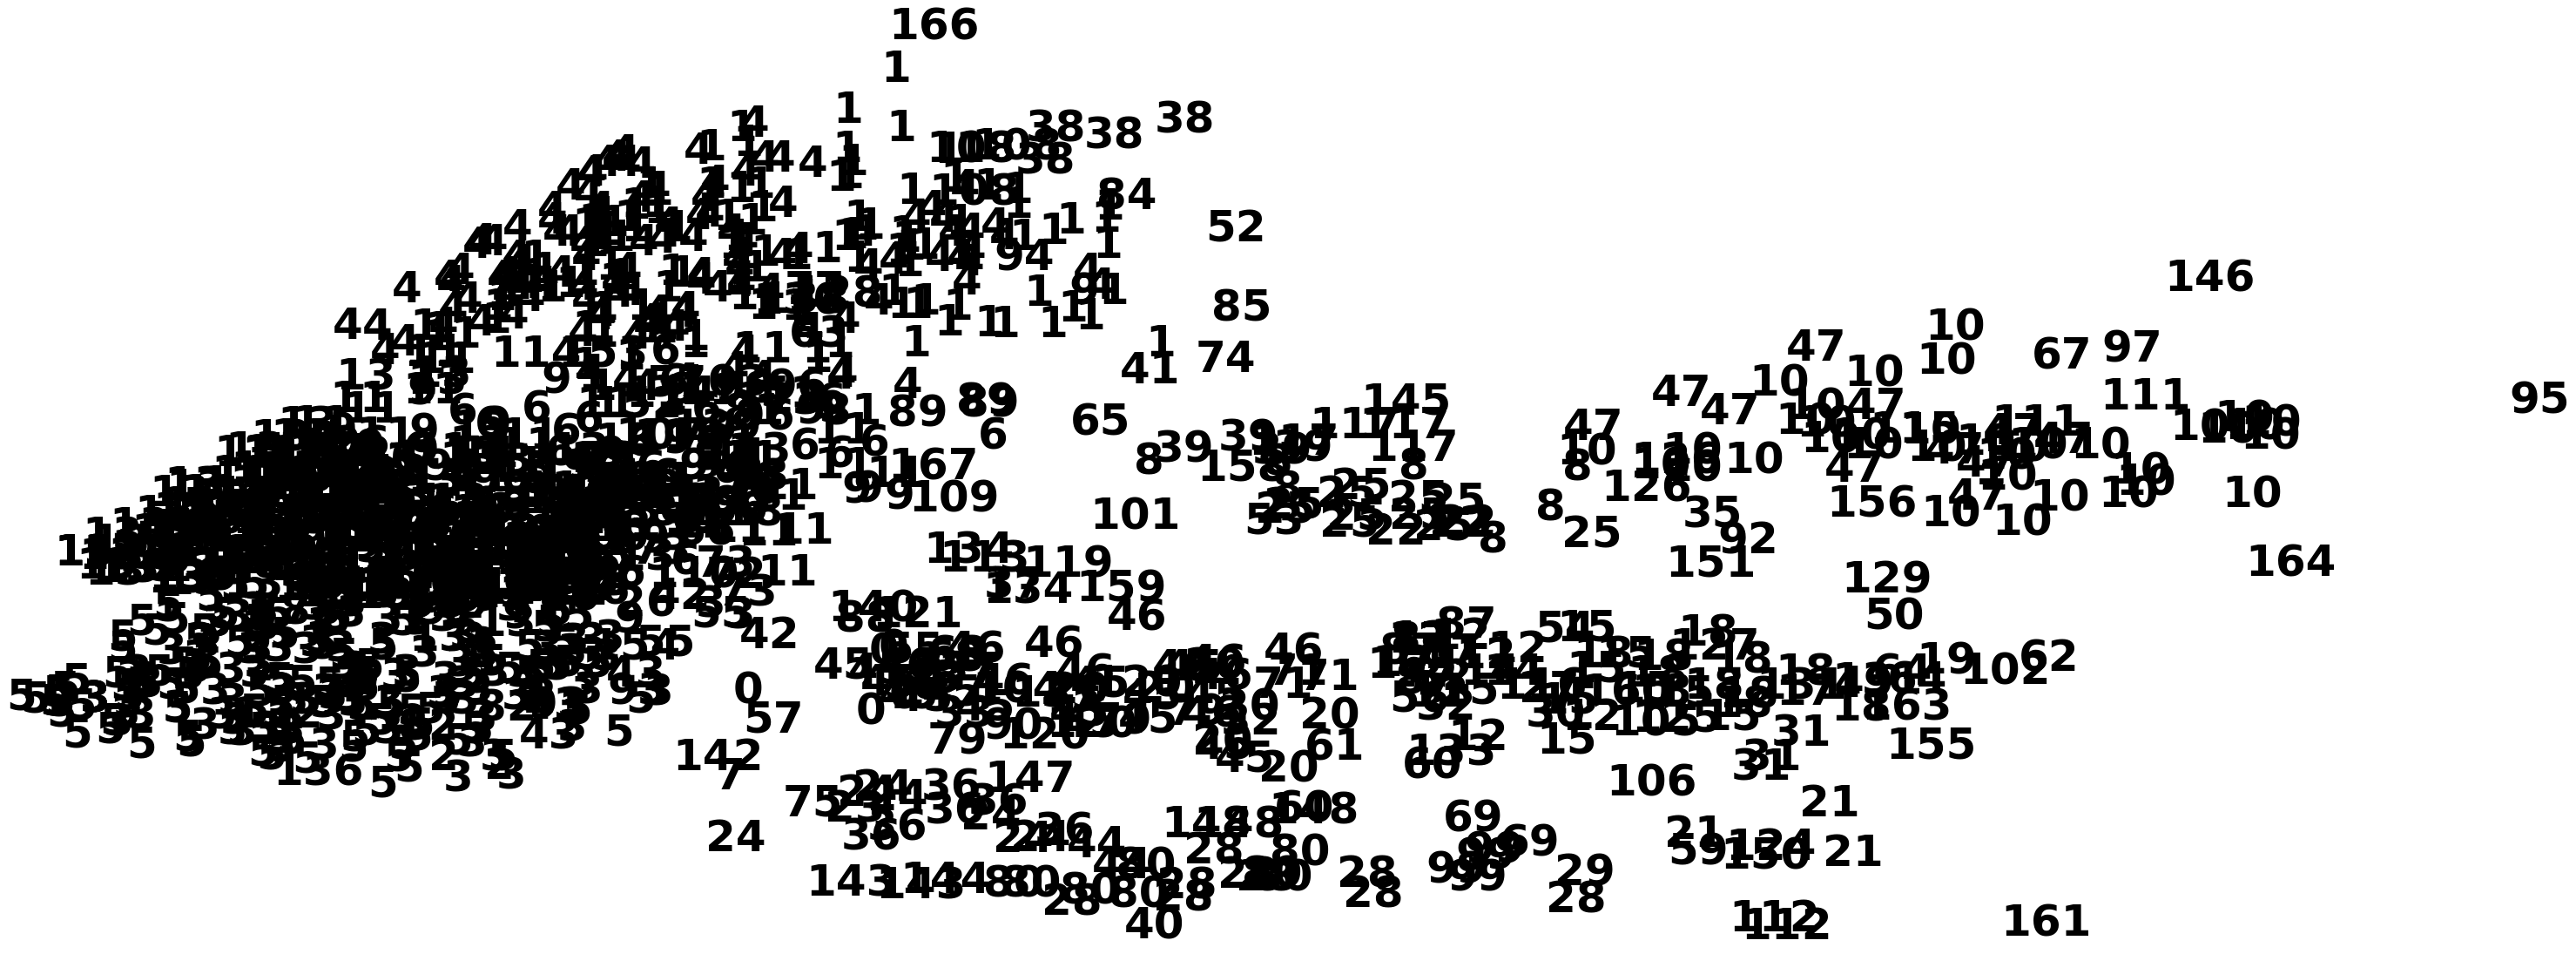

In [32]:
pca = PCA(n_components=2).fit_transform(X_std) #minimize variance with PCA

plt.figure(figsize=(7,3))
colours = 'rbg'
for i in range(pca.shape[0]):
    plt.text(pca[i, 0], pca[i, 1], str(clusters[i]), 
             fontdict={'weight': 'bold', 'size': 50} 
        )

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

We see very poor definition here, let's try adjusting our perameters. We'll start by increasing the number of samples.

In [33]:
#let's try increasing the number of samples
dbscan_cluster = DBSCAN(eps=1, min_samples=3, metric="euclidean")

# Fit model
clusters = dbscan_cluster.fit_predict(X_std)

print("Number of clusters when min_samples=1 is: {}".format(len(np.unique(clusters))))

min_samples_list = range(2,51)

for i in range(2,51):
    dbscan_cluster = DBSCAN(eps=1, min_samples=i, metric="euclidean")
    # Fit model
    clusters = dbscan_cluster.fit_predict(X_std)
    print("Number of clusters when min_samples={} is: {}".format(i, len(np.unique(clusters))))

Number of clusters when min_samples=1 is: 43
Number of clusters when min_samples=2 is: 66
Number of clusters when min_samples=3 is: 43
Number of clusters when min_samples=4 is: 30
Number of clusters when min_samples=5 is: 23
Number of clusters when min_samples=6 is: 14
Number of clusters when min_samples=7 is: 14
Number of clusters when min_samples=8 is: 11
Number of clusters when min_samples=9 is: 9
Number of clusters when min_samples=10 is: 10
Number of clusters when min_samples=11 is: 9
Number of clusters when min_samples=12 is: 9
Number of clusters when min_samples=13 is: 10
Number of clusters when min_samples=14 is: 10
Number of clusters when min_samples=15 is: 13
Number of clusters when min_samples=16 is: 14
Number of clusters when min_samples=17 is: 12
Number of clusters when min_samples=18 is: 12
Number of clusters when min_samples=19 is: 14
Number of clusters when min_samples=20 is: 13
Number of clusters when min_samples=21 is: 12
Number of clusters when min_samples=22 is: 9
N

As samples increase so do clusters, let's try increasing eps and see if we get the same pattern

In [34]:

dbscan_cluster = DBSCAN(eps=1, min_samples=1, metric="euclidean")

# Fit model
clusters = dbscan_cluster.fit_predict(X_std)

print("Number of clusters when eps=1 is: {}".format(len(np.unique(clusters))))

min_samples_list = range(2,51)

for i in [0.01,0.1,1,2,3,4,5,6,7,8,9,10]:
    dbscan_cluster = DBSCAN(eps=i, min_samples=1, metric="euclidean")
    # Fit model
    clusters = dbscan_cluster.fit_predict(X_std)
    print("Number of clusters when eps={} is: {}".format(i, len(np.unique(clusters))))

Number of clusters when eps=1 is: 168
Number of clusters when eps=0.01 is: 1326
Number of clusters when eps=0.1 is: 1264
Number of clusters when eps=1 is: 168
Number of clusters when eps=2 is: 19
Number of clusters when eps=3 is: 1
Number of clusters when eps=4 is: 1
Number of clusters when eps=5 is: 1
Number of clusters when eps=6 is: 1
Number of clusters when eps=7 is: 1
Number of clusters when eps=8 is: 1
Number of clusters when eps=9 is: 1
Number of clusters when eps=10 is: 1


As eps increases clusters are dropping

GMM Clustering

In [36]:
# Defining the agglomerative clustering
gmm_cluster = GaussianMixture(n_components=2, random_state=123) #consider using elbow method to strengthen choice of 
#number clusters 2

# Fit model
clus = gmm_cluster.fit_predict(X_std)

print("Silhouette score: {}".format(
    metrics.silhouette_score(X_std, clus, metric='euclidean')))

Silhouette score: 0.24811656868457374


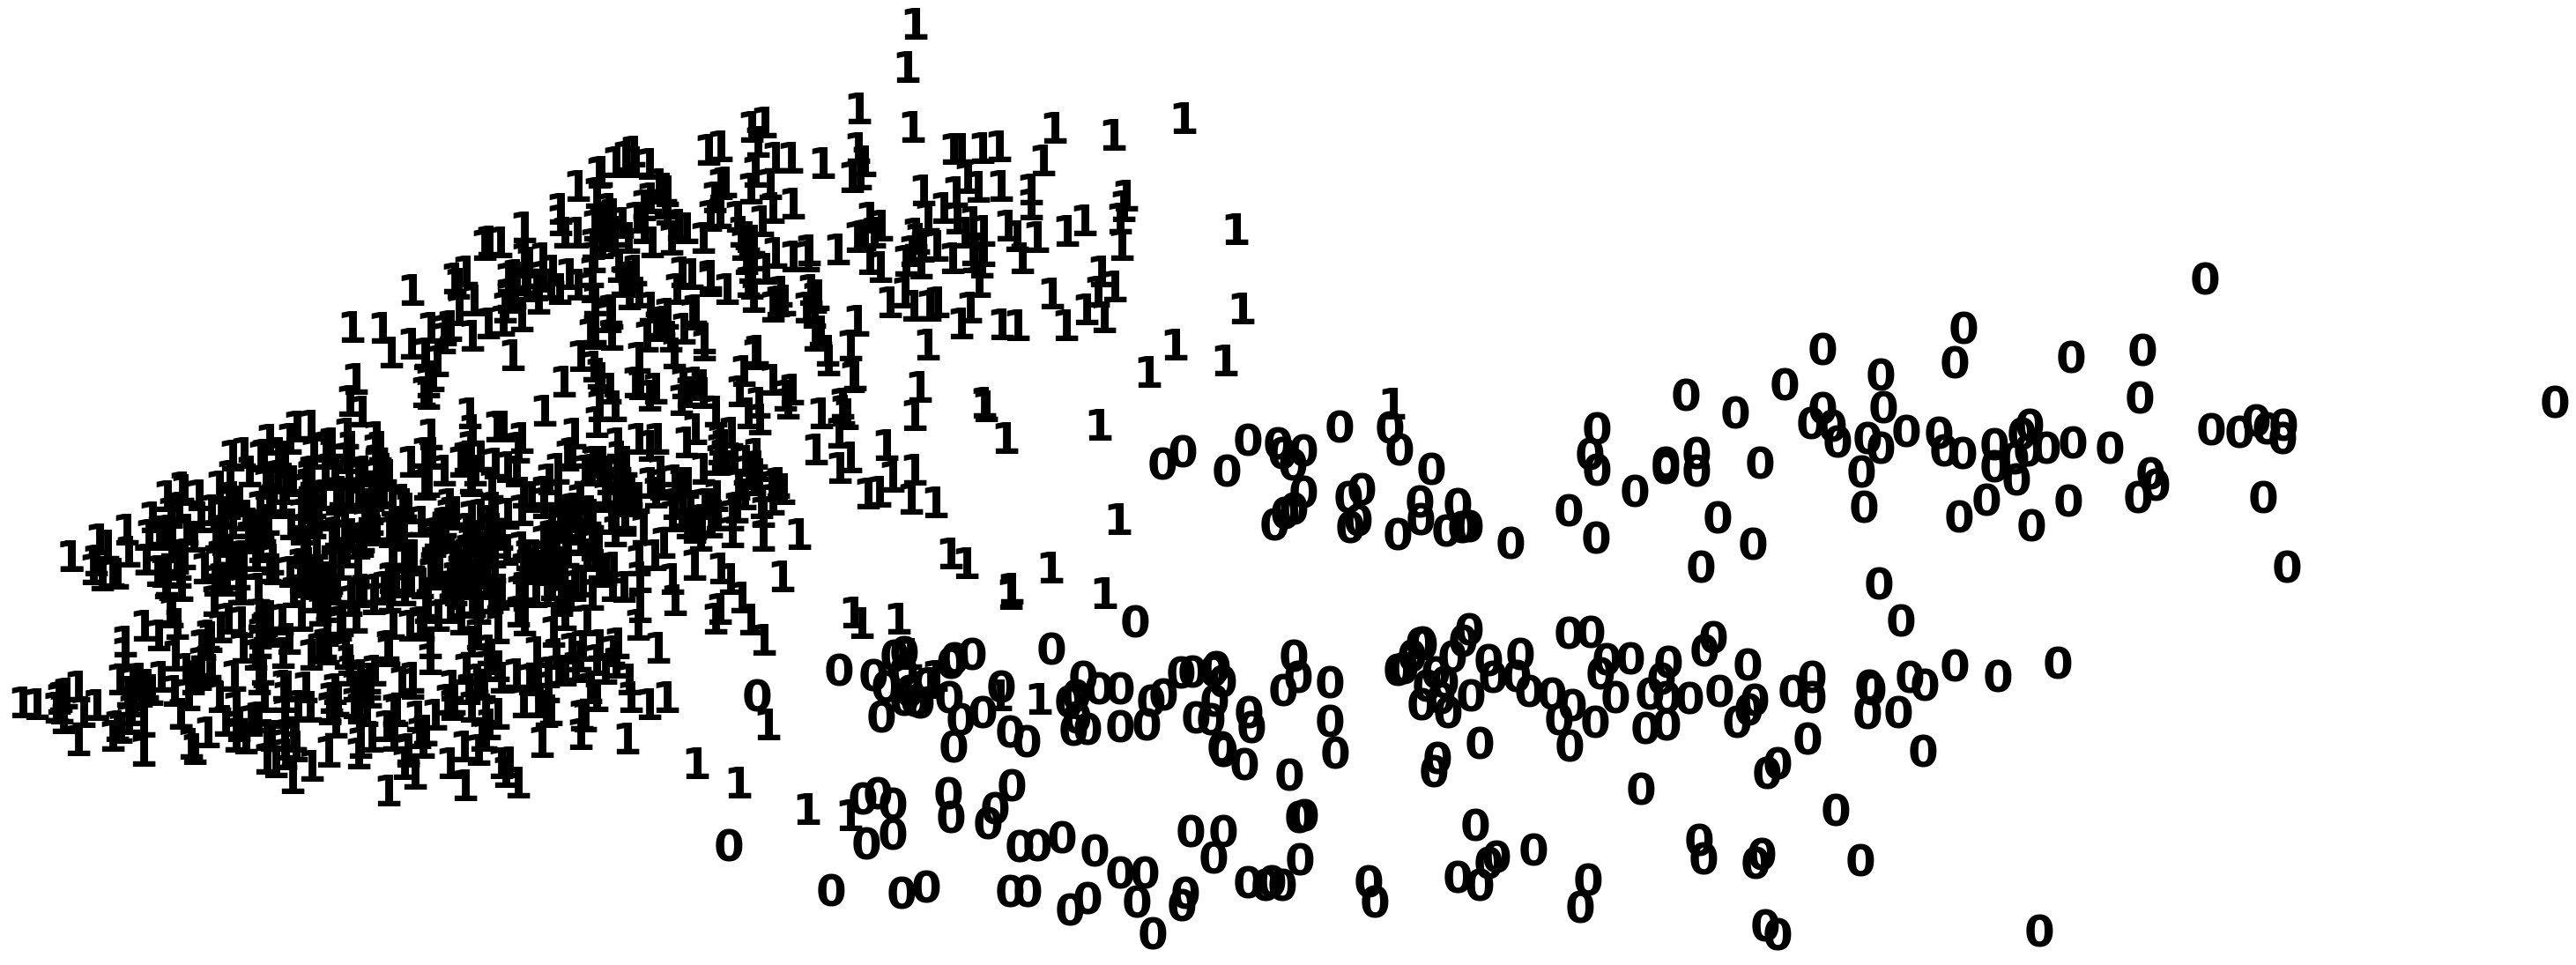

In [37]:
pca = PCA(n_components=2).fit_transform(X_std) #minimize variance with PCA

plt.figure(figsize=(7,3))
colours = 'rbg'
for i in range(pca.shape[0]):
    plt.text(pca[i, 0], pca[i, 1], str(clus[i]), 
             fontdict={'weight': 'bold', 'size': 50} 
        )

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

We see a decent silhouette score, same as our other models. Let's change our covariance types and see if there are any changes.

In [38]:
# Defining the agglomerative clustering
gmm_cluster = GaussianMixture(n_components=2, random_state=123, covariance_type="full")

# Fit model
clusters = gmm_cluster.fit_predict(X_std)

print("Silhouette score with covariance_type=full: {}".format(
    metrics.silhouette_score(X_std, clusters, metric='euclidean')))
print("------------------------------------------------------")

# Defining the agglomerative clustering
gmm_cluster = GaussianMixture(n_components=2, random_state=123, covariance_type="tied")

# Fit model
clusters = gmm_cluster.fit_predict(X_std)

print("Silhouette score with covariance_type=tied: {}".format(
    metrics.silhouette_score(X_std, clusters, metric='euclidean')))
print("------------------------------------------------------")

# Defining the agglomerative clustering
gmm_cluster = GaussianMixture(n_components=2, random_state=123, covariance_type="diag")

# Fit model
clusters = gmm_cluster.fit_predict(X_std)

print("Silhouette score with covariance_type=diag: {}".format(
    metrics.silhouette_score(X_std, clusters, metric='euclidean')))
print("------------------------------------------------------")


# Defining the agglomerative clustering
gmm_cluster = GaussianMixture(n_components=2, random_state=123, covariance_type="spherical")

# Fit model
clusters = gmm_cluster.fit_predict(X_std)

print("Silhouette score with covariance_type=spherical: {}".format(
    metrics.silhouette_score(X_std, clusters, metric='euclidean')))
print("------------------------------------------------------")

Silhouette score with covariance_type=full: 0.24811656868457374
------------------------------------------------------
Silhouette score with covariance_type=tied: 0.24811656868457374
------------------------------------------------------
Silhouette score with covariance_type=diag: 0.24811656868457374
------------------------------------------------------
Silhouette score with covariance_type=spherical: 0.24811656868457374
------------------------------------------------------


In [ ]:
#Silhouette score with covariance_type=full: 0.24811656868457374

#Silhouette score with covariance_type=tied: 0.24811656868457374

#Silhouette score with covariance_type=diag: 0.24811656868457374

#Silhouette score with covariance_type=spherical: 0.24811656868457374

No changes for the silhouette score for each of the covariance types. This is a pretty good model and performs on par in terms of datapoint density as GMM and DBSCAN

Let's apply dimensionality reduction strategies, perhaps we will find better performance with these techniques.


PCA Dimensionality Reduction



In [39]:
#randomizing our data
np.random.seed(123)

In [40]:
#grabbing the first two principal components
pca = PCA(n_components=2)

# We get the components by calling the fit and transform method from out data
pca_components = pca.fit_transform(X_std)

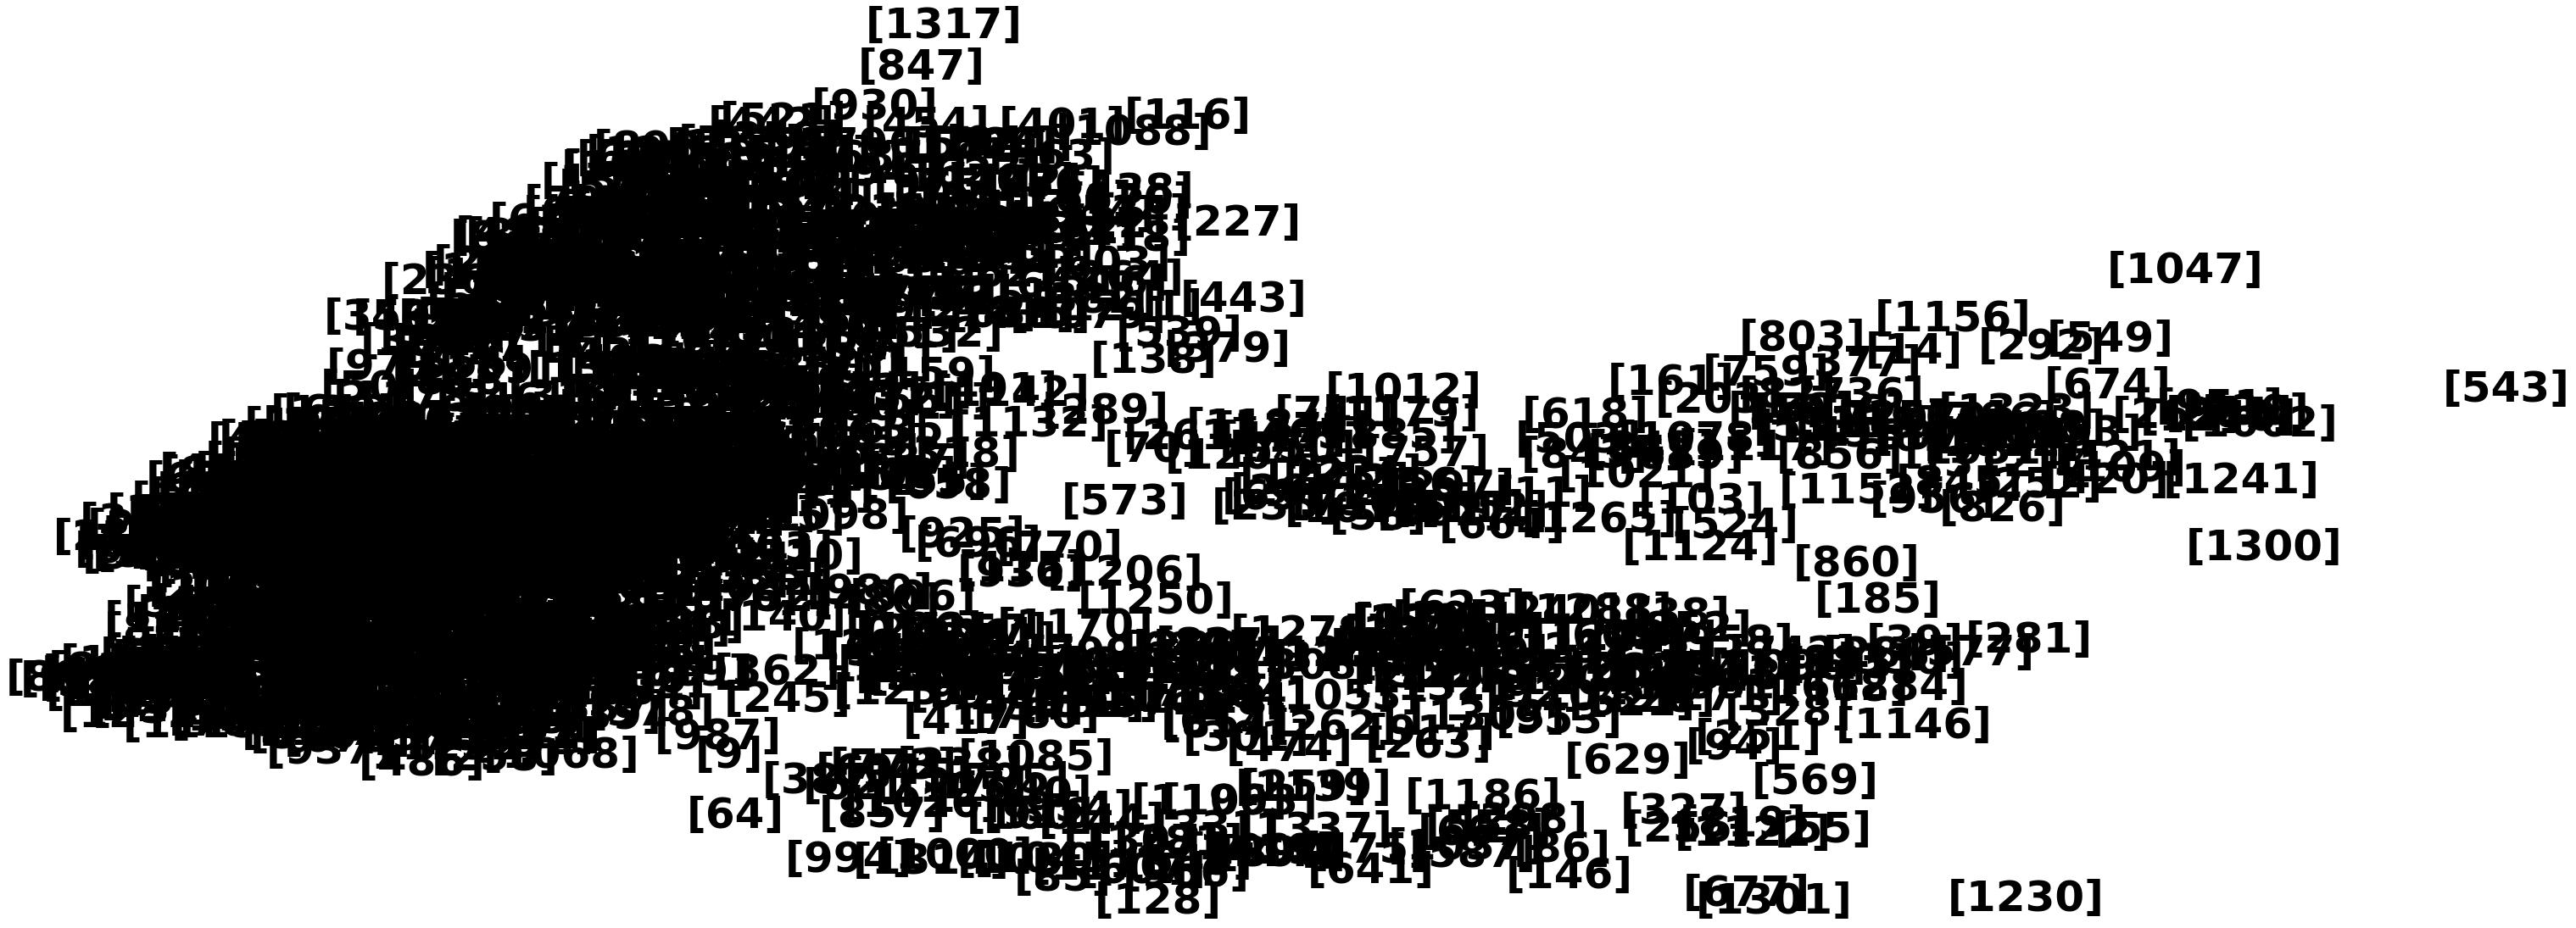

In [41]:
#visualize definition between classes
plt.figure(figsize=(7,3))
colours = ["r","b","g","c","m","y","k","r","burlywood","chartreuse"]
for i in range(pca_components.shape[0]):
    plt.text(pca_components[i, 0], pca_components[i, 1], str([i]),
             fontdict={'weight': 'bold', 'size': 50}
        )

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

We see very little definition between clasees, let's perform cluster analysis below, then try UMAP reduction which might work better than pca.



In [42]:
insurance_df['predict_clusters'] = pred_2

In [43]:
insurance_df.head()

age  children  male  yes  northwest  southeast  southwest  \
0   19         0     0    1          0          0          1   
1   18         1     1    0          0          1          0   
2   28         3     1    0          0          1          0   
3   33         0     1    0          1          0          0   
4   32         0     1    0          1          0          0   

   winsorized_expenses  winsorized_bmi  predict_clusters  
0             16884.92            27.9                 0  
1              3989.84            33.8                 1  
2              4449.46            33.0                 1  
3             21984.47            23.0                 1  
4              3989.84            28.9                 1

In [44]:
pd.set_option('display.max_columns', 500) #go back and re-read basic clustering analysis
pd.set_option('display.max_rows', 500)

insurance_df.groupby('predict_clusters').describe()


age                                                       \
                   count       mean        std   min    25%   50%   75%   max   
predict_clusters                                                                
0                  274.0  38.514599  13.923186  18.0  27.00  38.0  49.0  64.0   
1                 1064.0  39.385338  14.083410  18.0  26.75  40.0  52.0  64.0   

                 children                                               \
                    count      mean       std  min  25%  50%  75%  max   
predict_clusters                                                         
0                   274.0  1.113139  1.157066  0.0  0.0  1.0  2.0  5.0   
1                  1064.0  1.090226  1.218136  0.0  0.0  1.0  2.0  5.0   

                    male                                                  yes  \
                   count      mean       std  min  25%  50%  75%  max   count   
predict_clusters                                                                
0                  274.0  0.580292  0.494414  0.0  0.0  1.0  1.0  1.0   274.0   
1                 1064.0  0.485902  0.500036  0.0  0.0  0.0  1.0  1.0  1064.0   

                                                    northwest            \
                 mean  std  min  25%  50%  75%  max     count      mean   
predict_clusters                                                          
0                 1.0  0.0  1.0  1.0  1.0  1.0  1.0     274.0  0.211679   
1                 0.0  0.0  0.0  0.0  0.0  0.0  0.0    1064.0  0.250940   

                                                    southeast            \
                       std  min  25%  50%  75%  max     count      mean   
predict_clusters                                                          
0                 0.409246  0.0  0.0  0.0  0.0  1.0     274.0  0.332117   
1                 0.433758  0.0  0.0  0.0  1.0  1.0    1064.0  0.256579   

                                                    southwest            \
                       std  min  25%  50%  75%  max     count      mean   
predict_clusters                                                          
0                 0.471834  0.0  0.0  0.0  1.0  1.0     274.0  0.211679   
1                 0.436950  0.0  0.0  0.0  1.0  1.0    1064.0  0.250940   

                                                    winsorized_expenses  \
                       std  min  25%  50%  75%  max               count   
predict_clusters                                                          
0                 0.409246  0.0  0.0  0.0  0.0  1.0               274.0   
1                 0.433758  0.0  0.0  0.0  1.0  1.0              1064.0   

                                                                              \
                          mean           std       min        25%        50%   
predict_clusters                                                               
0                 32050.231971  11541.547338  12829.46  20826.245  34456.350   
1                  8817.480977   5623.875180   3989.84   3989.840   7345.405   

                                      winsorized_bmi                       \
                        75%       max          count       mean       std   
predict_clusters                                                            
0                 41019.205  63770.43          274.0  30.960219  5.930234   
1                 11362.890  36910.61         1064.0  30.875564  5.680422   

                                                 
                   min   25%    50%   75%   max  
predict_clusters                                 
0                 23.0  26.1  30.45  35.2  52.6  
1                 23.0  26.3  30.35  34.4  53.1

Analysis:

We can see strong overlap in our descriptive stats for both clusters 0 and 1. For children the mean is around 1, for age we see a similar mean of roughly 39, and for bmi we see the same mean of 30. However, there is a massive descrepency in expenses between group 0 and 1, respectively we see roughly 32k and 9k. Group 0 has higher expenses therefore we can expect a higher premium price for group 0 than group 1. 

UMAP Dimensionality Reduction

In [45]:
#randomize first
np.random.seed(123)

print(X_std.shape)

(1338, 9)


In [46]:
#apply UMAP dimensionality reduction technique

umap_results = umap.UMAP(n_neighbors=5,
                      min_dist=0.3,
                      metric='correlation').fit_transform(X_std)

In [47]:
plt.figure(figsize=(7,3))
colours = ["r","b","g","c","m","y","k","r","burlywood","chartreuse"]
for i in range(umap_results.shape[0]):
    plt.text(umap_results[i, 0], umap_results[i, 1], [i],
             fontdict={'weight': 'bold', 'size': 50}
        )

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

In [48]:
plt.figure(figsize=(10,5))
plt.scatter(umap_results[:, 0], umap_results[:, 1])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

We see better differentiation between clustering. Let's try changing the different perameters.


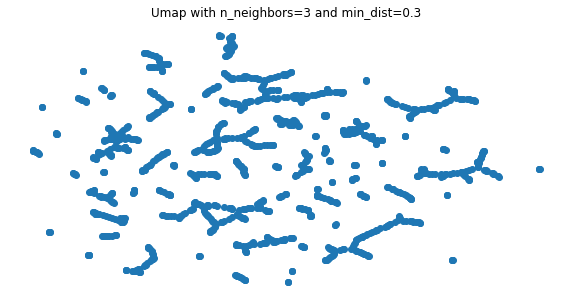

In [50]:
umap_results = umap.UMAP(n_neighbors=3,
                      min_dist=0.3,
                      metric='correlation').fit_transform(X_std)

plt.figure(figsize=(10,5))
plt.title("Umap with n_neighbors=3 and min_dist=0.3")
plt.scatter(umap_results[:, 0], umap_results[:, 1])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

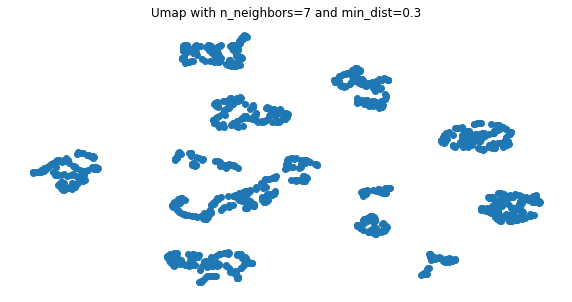

In [51]:
umap_results = umap.UMAP(n_neighbors=7,
                      min_dist=0.3,
                      metric='correlation').fit_transform(X_std)

plt.figure(figsize=(10,5))
plt.title("Umap with n_neighbors=7 and min_dist=0.3")
plt.scatter(umap_results[:, 0], umap_results[:, 1])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

With minimum distance = 0.3 and nearest number of neighbors = 7 we actually see a pretty good clustering effect as there is definitive seperation between our classes, however, this visualization does not include coloration to define the classes.

Results:

The best unsupervised learning clustering technique to use for this dataset is K-Means Mini Batch for a 2 cluster sample, where the the silhouette score of 0.24 is fairly good and is indicative of moderate density levels amongst our datapoints. Addtionally, when evaluating the descriptive stats between the two clusters we the greatest difference in medical expenses, a discrepency between 32,000 and 9,000.

We know that k-means clustering model does a great job of keeping the clusters it produces tight, and also it performs well on larger datasets. 

Discussion:

The ideal individual who would benefit from my findings, would be a pricing analyst or risk analyst for a medical insurance company. This would help the invidual recognize which features are most similar and therefore determine how to appropriate certain policy holders for example into group 0 and group 1 based on their current level of medical expenses. 

There are a few shortcomings here with this model as well as many of the others, I would have liked to have seen a higher silhouette score, and my dataset could have been larger. Perhaps if there had been more features in the dataset we would have seen this. If I were to expand on this research I would find many more features that answer questions regarding nutrition and preexisting health conditions. Because group 0 had much higher expenses than group 1 it would be important to evaluate more variables that could explain why group 0 has higher expenses. 